<a href="https://colab.research.google.com/github/sarahcodebyte/Gett-Analysis-StrataScratch/blob/main/Gett_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Description**:

This notebook is for the analysis of the Gett's company data which is an Israeli-developed technology platform solely focused on corporate Ground Transportation Management (GTM). They have an application where clients can order taxis, and drivers can accept their rides (offers). At the moment, when the client clicks the Order button in the application, the matching system searches for the most relevant drivers and offers them the order. In this task, we would like to investigate some matching metrics for orders that did not completed successfully, i.e., the customer didn't end up getting a car.


This project aims to analyse the data and provide insights on the following queries:


*   Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment and reasons for order rejection. Analyze the resulting plot. Which category has the highest number of orders?

*   Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest failures? Explain.

*   Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

*   Plot the distribution of average ETA by hours. How can this plot be explained?


This is a project under the GirlScript Summer of Code'23, issue no #258.


Developed by: Sarah Shruti Kujur

Connect on GitHub: [sarahcodebyte](https://github.com/sarahcodebyte)

# **Importing Dependencies:**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# **Loading Datasets:**

In [ ]:
offers = pd.read_csv('/content/data_offers.csv')
order = pd.read_csv('/content/data_orders.csv')

In [ ]:
offers.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [ ]:
offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116508 entries, 0 to 116507
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   order_gk  116508 non-null  int64
 1   offer_id  116508 non-null  int64
dtypes: int64(2)
memory usage: 1.8 MB


In [ ]:
order.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [ ]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


# **Data Preprocessing and Analysis:**

In [ ]:
order.isna().mean().mul(100).round(2)

order_datetime                    0.00
origin_longitude                  0.00
origin_latitude                   0.00
m_order_eta                      73.74
order_gk                          0.00
order_status_key                  0.00
is_driver_assigned_key            0.00
cancellations_time_in_seconds    31.81
dtype: float64



*   73% of data in the `column m_order_eta` is null or empty
*   31% of data in the `cancellation_time_in_seconds` is null or empty



In [ ]:
offers.isna().mean().mul(100).round(2)

order_gk    0.0
offer_id    0.0
dtype: float64

***1. Distribution of Cancellations***

In [ ]:
#distribution of cancellations
plot = order.groupby(['is_driver_assigned_key', 'order_status_key'])['order_gk'].count().reset_index()
plot

,is_driver_assigned_key,order_status_key,order_gk
0,0,4,4496
1,0,9,3406
2,1,4,2811
3,1,9,3


In [ ]:
order[order['is_driver_assigned_key']==0]['order_status_key'].value_counts(normalize=True)

4    0.56897
9    0.43103
Name: order_status_key, dtype: float64

In [ ]:
order[order['is_driver_assigned_key']==1]['order_status_key'].value_counts(normalize=True)

4    0.998934
9    0.001066
Name: order_status_key, dtype: float64

In [ ]:
order['is_cancelled_by_customer'] = (order['order_status_key']==4)*1

Text(0.5, 0, 'Category')

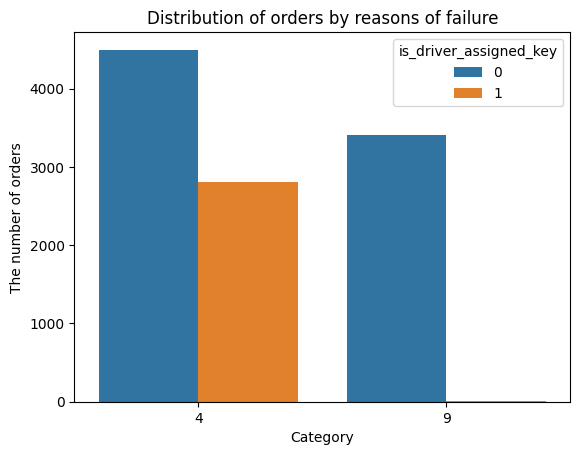

In [ ]:
cancel_plot = sns.barplot(data = plot, x = 'order_status_key', y = 'order_gk', hue = 'is_driver_assigned_key')
cancel_plot.set_title('Distribution of orders by reasons of failure')
cancel_plot.set_ylabel('The number of orders')
cancel_plot.set_xlabel('Category')

* Client cancelations are higher than the company rejections.

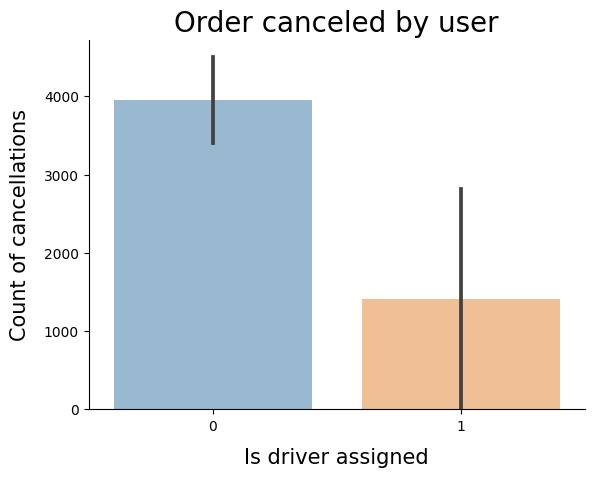

In [ ]:

sns.barplot(
    x='is_driver_assigned_key',
    y='order_gk',
    data=plot,
    alpha = 0.5
    )

plt.xlabel("Is driver assigned", size=15, labelpad=10)
plt.ylabel("Count of cancellations", size=15, labelpad=10)
plt.title("Order canceled by user", size=20)
sns.despine()

***2. Cancelation by time***

In [ ]:
order['hours'] = order['order_datetime'].str[:2]

In [ ]:
order

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,is_cancelled_by_customer,hours
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,1,18
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,1,20
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,1,12
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,1,13
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN,0,21
...,...,...,...,...,...,...,...,...,...,...
10711,13:11:35,-0.975372,51.457846,NaN,3000599186906,4,0,36.0,1,13
10712,13:13:55,-0.975372,51.457846,NaN,3000599186962,4,0,4.0,1,13
10713,13:17:21,-0.972926,51.457693,60.0,3000599187034,4,1,34.0,1,13
10714,13:16:28,-0.975372,51.457846,NaN,3000599187024,4,0,6.0,1,13


In [ ]:
client_cans = order[order['order_status_key']==4].groupby('hours')['is_cancelled_by_customer'].agg(['count'])

In [ ]:
reject_cans = order[order['order_status_key']==9].groupby('hours')['is_cancelled_by_customer'].agg(['count'])

Text(0, 0.5, 'No of orders')

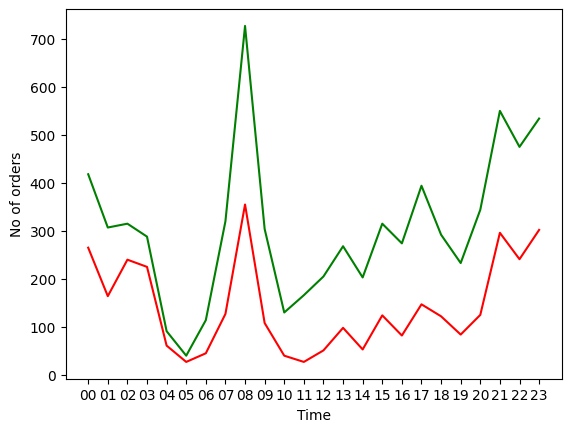

In [ ]:
a = sns.lineplot(data=reject_cans,  x = 'hours', y = 'count', color = 'red')
b = sns.lineplot(data=client_cans,  x = 'hours', y = 'count', color = 'green')

a.set_xlabel('Time')
a.set_ylabel('No of orders')

A sharp increase in cancelations can be seen at around 8:00AM in both client refusals and rejections by the app.

In [ ]:
no_driver = order.query('is_driver_assigned_key == 0').groupby('order_status_key').agg({'order_gk' : 'count'}).reset_index()

In [ ]:
no_driver['distribution'] = no_driver['order_gk']/no_driver['order_gk'].sum()

In [ ]:
with_driver = order.query('is_driver_assigned_key == 1').groupby('order_status_key').agg({'order_gk' : 'count'}).reset_index()

In [ ]:
with_driver['distribution'] = with_driver['order_gk']/with_driver['order_gk'].sum()

In [ ]:
print(no_driver['distribution'].round(3))
print(with_driver['distribution'].round(3))

0    0.569
1    0.431
Name: distribution, dtype: float64
0    0.999
1    0.001
Name: distribution, dtype: float64




*   If a driver is assigned, customer-initiated cancelations are upto 57% of orders, while the system cancels around 43% of the orders
*   If no driver is assigned, customer-initiated cancelations are upto 99% of orders and system cancels 1% of the order


***3. Average time to cancel the ride with and without the driver being assigned***

In [ ]:
order.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,is_cancelled_by_customer,hours
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,1,18
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,1,20
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,1,12
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,1,13
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN,0,21


<Axes: >

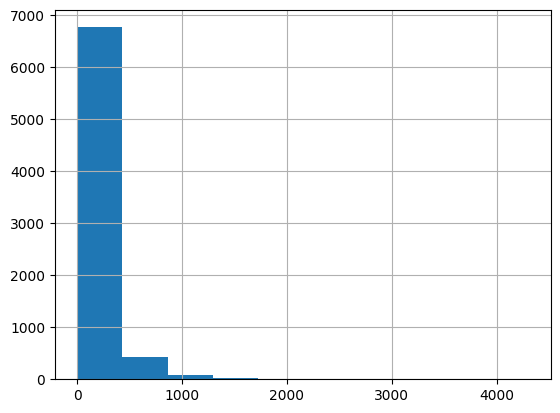

In [ ]:
order.cancellations_time_in_seconds.hist()

In [ ]:
(order.cancellations_time_in_seconds>1000).mean()

0.006718924972004479

*  There is very small part of outliers.




In [ ]:
order[order['cancellations_time_in_seconds']<=1000].groupby('is_driver_assigned_key')['cancellations_time_in_seconds'].agg(['mean', 'median', 'count'])

,mean,median,count
is_driver_assigned_key,,,
0,108.189087,88.0,4490
1,205.276503,121.0,2745


In [ ]:
with_driver = order[order['is_driver_assigned_key']==1].groupby('hours')['cancellations_time_in_seconds'].agg(['mean', 'median'])

In [ ]:
no_driver = order[order['is_driver_assigned_key']==0].groupby('hours')['cancellations_time_in_seconds'].agg(['mean', 'median'])

Text(0, 0.5, 'Avg cancellation Time')

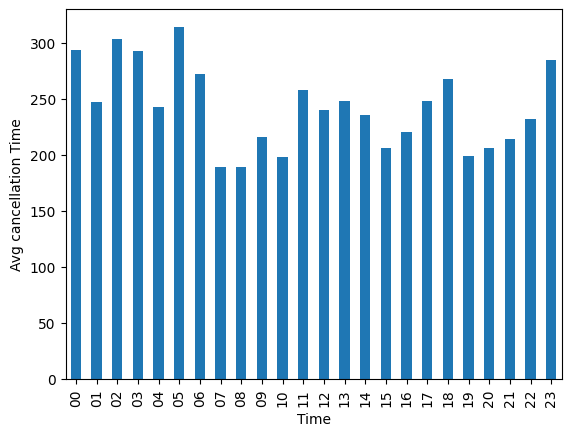

In [ ]:
#avg cancellation time by hours with driver assigned
cans_plot_with_driver = with_driver['mean'].plot(kind = 'bar')
cans_plot_with_driver.set_xlabel('Time')
cans_plot_with_driver.set_ylabel('Avg cancellation Time')

Text(0, 0.5, 'Avg cancellation Time')

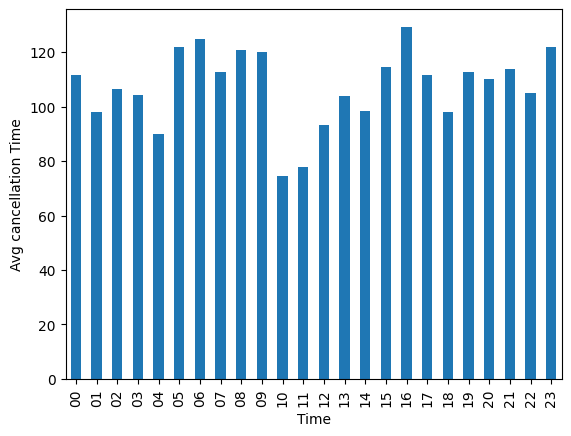

In [ ]:
#avg cancellation time by hours without any driver assigned
cans_plot_no_driver = no_driver['mean'].plot(kind = 'bar')
cans_plot_no_driver.set_xlabel('Time')
cans_plot_no_driver.set_ylabel('Avg cancellation Time')

In [ ]:
no_d = no_driver['mean'].mean()
with_d = with_driver['mean'].mean()

print(f'Avg cancellation time if driver was assigned: {with_d}', f'Av cancellation time of no driver was assigned: {no_d}', sep = '\n')

Avg cancellation time if driver was assigned: 242.60632353041066
Av cancellation time of no driver was assigned: 107.31176564166906




*   When no driver is assigned then the cancellation is less
*   Both the graphs have distribution similar to uniform



***4. Distribution of avg ETA(estimated time of arrival) by hours***

In [ ]:
order.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,is_cancelled_by_customer,hours
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,1,18
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,1,20
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,1,12
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,1,13
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN,0,21


In [ ]:
order['m_order_eta'].describe()

count    2814.000000
mean      441.415423
std       288.006379
min        60.000000
25%       233.000000
50%       368.500000
75%       653.000000
max      1559.000000
Name: m_order_eta, dtype: float64

<Axes: >

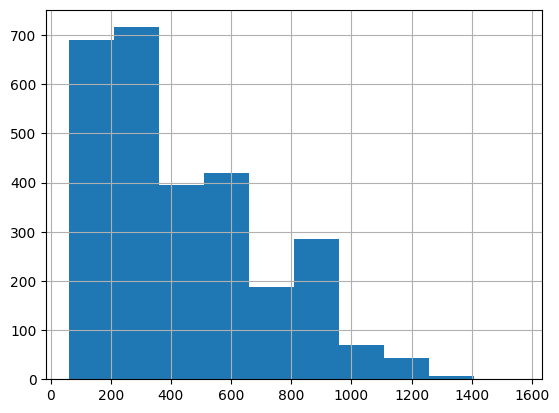

In [ ]:
order['m_order_eta'].hist()

In [ ]:
order.m_order_eta.isna().mean()

0.7374020156774916

In [ ]:
eta = order.groupby('hours')['m_order_eta'].agg(['mean', 'count', 'median']).reset_index()

Text(0.5, 0, 'Hours')

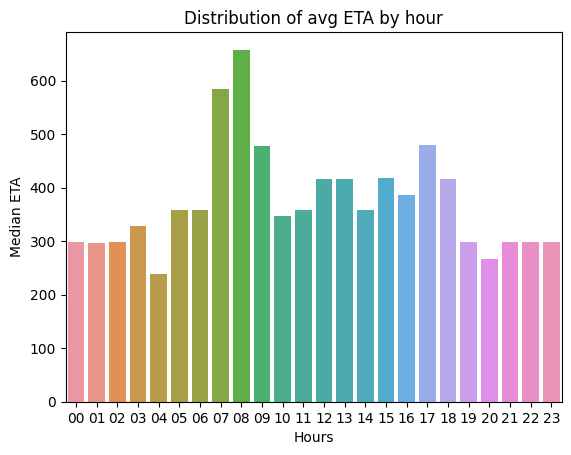

In [ ]:
eta_plot = sns.barplot(data = eta, x = 'hours', y =  'median')
eta_plot.set_title('Distribution of avg ETA by hour')
eta_plot.set_ylabel('Median ETA')
eta_plot.set_xlabel('Hours')

Text(0.5, 0, 'Hours')

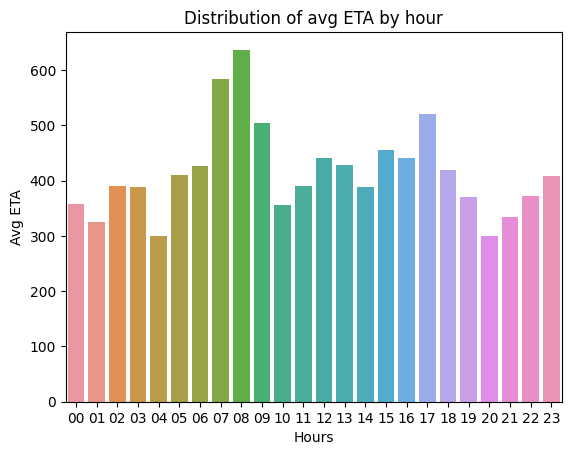

In [ ]:
eta_plot = sns.barplot(data = eta, x = 'hours', y =  'mean')
eta_plot.set_title('Distribution of avg ETA by hour')
eta_plot.set_ylabel('Avg ETA')
eta_plot.set_xlabel('Hours')



*   ETA is higher during morning rush hours

